## Random oversampling: Duplicating existing instances in the minority class

In [3]:
# Attention: It's simpler than SMOTE, but it can lead to overfitting 
# since the model might learn to recognize specific duplicated instances rather than generalizing patterns.

Logistic Regression Test Set Evaluation:
Accuracy: 0.8080257793444783
Confusion Matrix:
 [[70401 13853]
 [18496 65757]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.84      0.81     84254
           1       0.83      0.78      0.80     84253

    accuracy                           0.81    168507
   macro avg       0.81      0.81      0.81    168507
weighted avg       0.81      0.81      0.81    168507

Random Forest Test Set Evaluation:
Accuracy: 0.989288278825212
Confusion Matrix:
 [[82449  1805]
 [    0 84253]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     84254
           1       0.98      1.00      0.99     84253

    accuracy                           0.99    168507
   macro avg       0.99      0.99      0.99    168507
weighted avg       0.99      0.99      0.99    168507

Gradient Boosting Test Set Evaluation:
Accuracy: 0.80921267365747

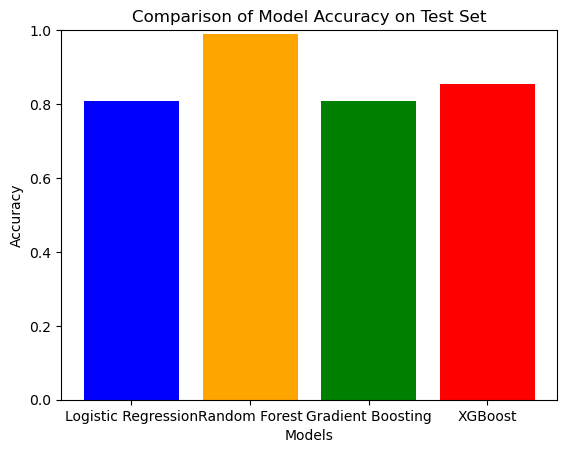

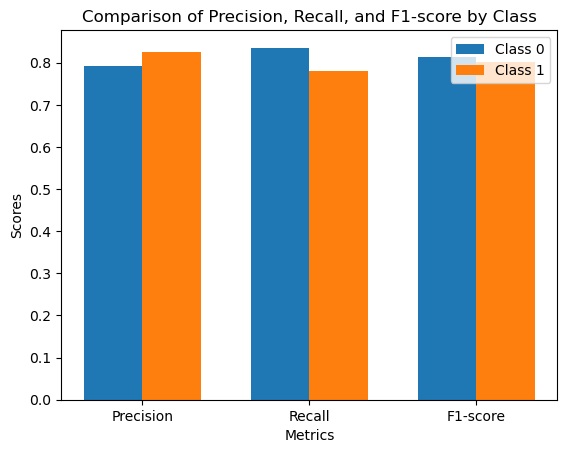

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb

# Load data set into pandas
df = pd.read_csv("Cleaned_dataset.csv")

# Identify binary columns
binary_columns = [column for column in df.columns if df[column].nunique() == 2]
# Convert binary columns to 0 and 1
for col in binary_columns:
    unique_values = df[col].unique()
    if set(unique_values) == {"Yes", "No"}:
        df[col] = df[col].map({"Yes": 1, "No": 0})

categorical_columns = ['Sex', 'GeneralHealth', 'LastCheckupTime', 'RemovedTeeth', 'HadDiabetes',
                       'SmokerStatus', 'ECigaretteUsage', 'RaceEthnicityCategory', 'AgeCategory',
                       'HighRiskLastYear', 'CovidPos']

# Extract the categorical columns into a new DataFrame
Categorical_col = df[categorical_columns]

# Use pd.get_dummies to transform the categorical columns
Transform_df = pd.get_dummies(Categorical_col, dtype=int)

# Select numeric columns
numeric_columns = df.select_dtypes(include=["float64"]).columns
df_numeric = df[numeric_columns]

# Create standard scaler instance, fitting it, and scaling it
scaler = StandardScaler()
scaled_numeric_df = pd.DataFrame(scaler.fit_transform(df_numeric), columns=numeric_columns)

# Drop the original columns
df = df.drop(columns=categorical_columns + numeric_columns.tolist())

# Combine the original DataFrame and the dummy variables DataFrame
merged_df = pd.concat([df, Transform_df, scaled_numeric_df], axis=1)
merged_df = merged_df.drop(columns='State')


# Separate the majority and minority classes
majority_class = merged_df[merged_df.HadHeartAttack == 0]
minority_class = merged_df[merged_df.HadHeartAttack == 1]

# Perform random oversampling of the minority class
minority_class_oversampled = resample(minority_class, 
                                      replace=True,    # Sample with replacement
                                      n_samples=len(majority_class),  # Match number in majority class
                                      random_state=42)  # For reproducibility

# Combine the oversampled minority class with the majority class
oversampled_df = pd.concat([majority_class, minority_class_oversampled])

# Split the data into features and target variable
X = oversampled_df.drop(columns="HadHeartAttack")
y = oversampled_df["HadHeartAttack"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Create and fit the Logistic Regression model
classifier = LogisticRegression(solver='lbfgs', max_iter=200, random_state=42)
classifier.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred_test = classifier.predict(X_test)
print("Logistic Regression Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

# Method 2: Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred_test_rf = rf_classifier.predict(X_test)
print("Random Forest Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_test_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_test_rf))

# Method 3: Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_classifier.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred_test_gb = gb_classifier.predict(X_test)
print("Gradient Boosting Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_test_gb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test_gb))
print("Classification Report:\n", classification_report(y_test, y_pred_test_gb))

# Method 4: XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(random_state=42)
xgb_classifier.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred_test_xgb = xgb_classifier.predict(X_test)
print("XGBoost Test Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_test_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_test_xgb))

# Plot the comparison of accuracy
labels = ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'XGBoost']
accuracies = [
    accuracy_score(y_test, y_pred_test),
    accuracy_score(y_test, y_pred_test_rf),
    accuracy_score(y_test, y_pred_test_gb),
    accuracy_score(y_test, y_pred_test_xgb)
]

plt.bar(labels, accuracies, color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracy on Test Set')
plt.ylim(0, 1)
plt.show()

# Plot the comparison of precision, recall, and f1-score
labels = ['Precision', 'Recall', 'F1-score']
class_0_scores = [precision_score(y_test, y_pred_test, pos_label=0), recall_score(y_test, y_pred_test, pos_label=0), f1_score(y_test, y_pred_test, pos_label=0)]
class_1_scores = [precision_score(y_test, y_pred_test, pos_label=1), recall_score(y_test, y_pred_test, pos_label=1), f1_score(y_test, y_pred_test, pos_label=1)]

x = list(range(len(labels)))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar([i - width/2 for i in x], class_0_scores, width, label='Class 0')
rects2 = ax.bar([i + width/2 for i in x], class_1_scores, width, label='Class 1')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Precision, Recall, and F1-score by Class')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()
